In [1]:
# read high-level file 
import sys
sys.path.append('../')
from domains.samplers import *
# autoreload 
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import json
import warnings

# ignore below warnings
# A value is trying to be set on a copy of a slice from a DataFrame.
# Try using .loc[row_indexer,col_indexer] = value instead
warnings.filterwarnings('ignore')


# Data Creation

In [2]:

# test the synthetic data sampler
num_modules = 10
feature_dim = 3
composition_type = "parallel"
fixed_structure = True
max_depth = num_modules
num_trees = 5000
seed = 42
data_dist = "uniform"
module_function_type_list = ["quadratic_module"]
resample = True
sampler = SyntheticDataSampler(num_modules, feature_dim, composition_type, fixed_structure, max_depth, num_trees, seed, data_dist, module_function_type_list, resample=resample, heterogeneity=1.0)
sampler.simulate_data()


num_modules:  10
Reinitializing path 0
Reinitializing path 1
Reinitializing csv folder
Writing CSV data to files for each module.
{8: ['feature_0', 'feature_1', 'feature_2'], 5: ['feature_0', 'feature_1', 'feature_2'], 1: ['feature_0', 'feature_1', 'feature_2'], 9: ['feature_0', 'feature_1', 'feature_2'], 7: ['feature_0', 'feature_1', 'feature_2'], 2: ['feature_0', 'feature_1', 'feature_2'], 3: ['feature_0', 'feature_1', 'feature_2'], 10: ['feature_0', 'feature_1', 'feature_2'], 4: ['feature_0', 'feature_1', 'feature_2'], 6: ['feature_0', 'feature_1', 'feature_2']}


In [3]:
# read the data
data_path = "/Users/ppruthi/research/novelty_accommodation/compositional_models_cate/domains/synthetic_data/csvs/fixed_structure_True_outcomes_parallel/synthetic_data_data_high_level_features.csv"
data = pd.read_csv(data_path)

# data["total_output"] = data["module_1_output"] + data["module_2_output"] + data["module_3_output"] + data["module_4_output"]
# data["diff"] = data["total_output"] - data["query_output"]
data.head()

,query_id,treatment_id,tree_depth,num_module_1,num_module_2,num_module_3,num_module_4,num_module_5,num_module_6,num_module_7,...,module_2_output,module_3_output,module_4_output,module_5_output,module_6_output,module_7_output,module_8_output,module_9_output,module_10_output,query_output
0,2017,0,10,1,1,1,1,1,1,1,...,1.571229,1.404904,1.554001,2.077567,3.159778,3.000253,2.513122,0.985712,1.414577,19.948682
1,2447,0,10,1,1,1,1,1,1,1,...,1.850238,0.413547,1.501611,3.046885,2.249043,1.649672,1.369179,0.959718,0.325385,15.675937
2,812,0,10,1,1,1,1,1,1,1,...,2.238342,0.702363,1.776111,2.468983,2.141722,1.246371,1.258481,1.315547,1.380669,17.784933
3,3606,0,10,1,1,1,1,1,1,1,...,1.634628,0.756389,0.406761,2.932653,2.057121,2.007446,2.044611,1.174084,1.309039,15.872137
4,2914,0,10,1,1,1,1,1,1,1,...,1.501333,1.174883,0.947568,3.139309,2.015839,2.861188,0.699200,1.414486,0.940378,16.802053


# Data Analysis

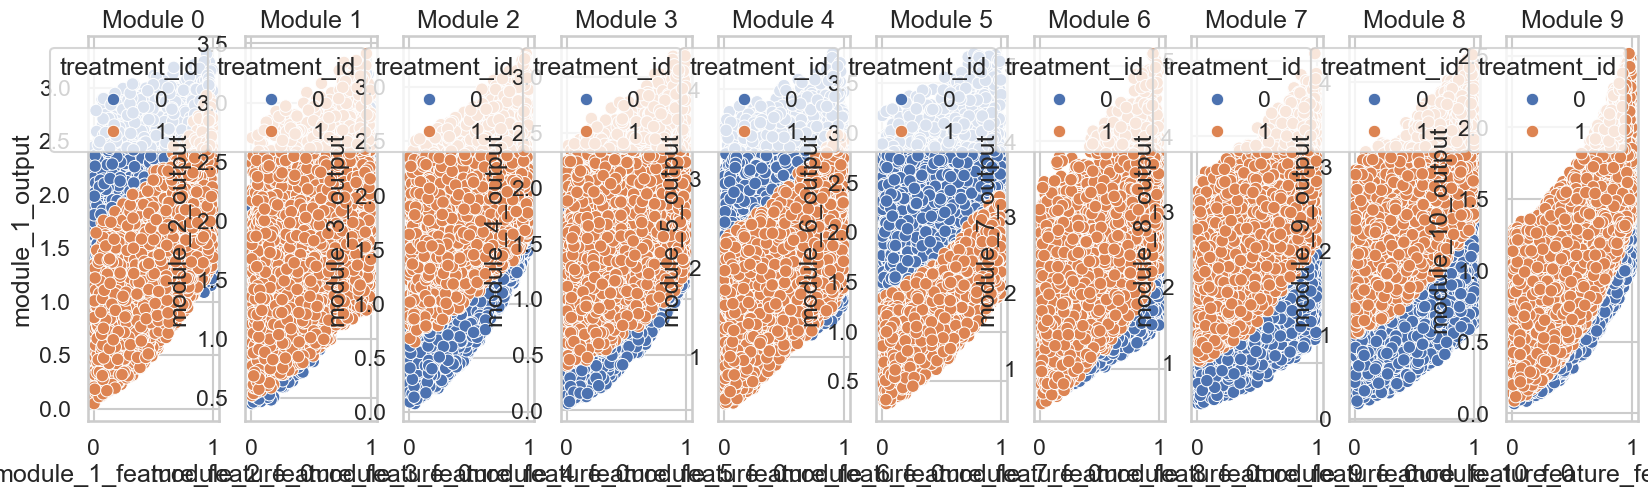

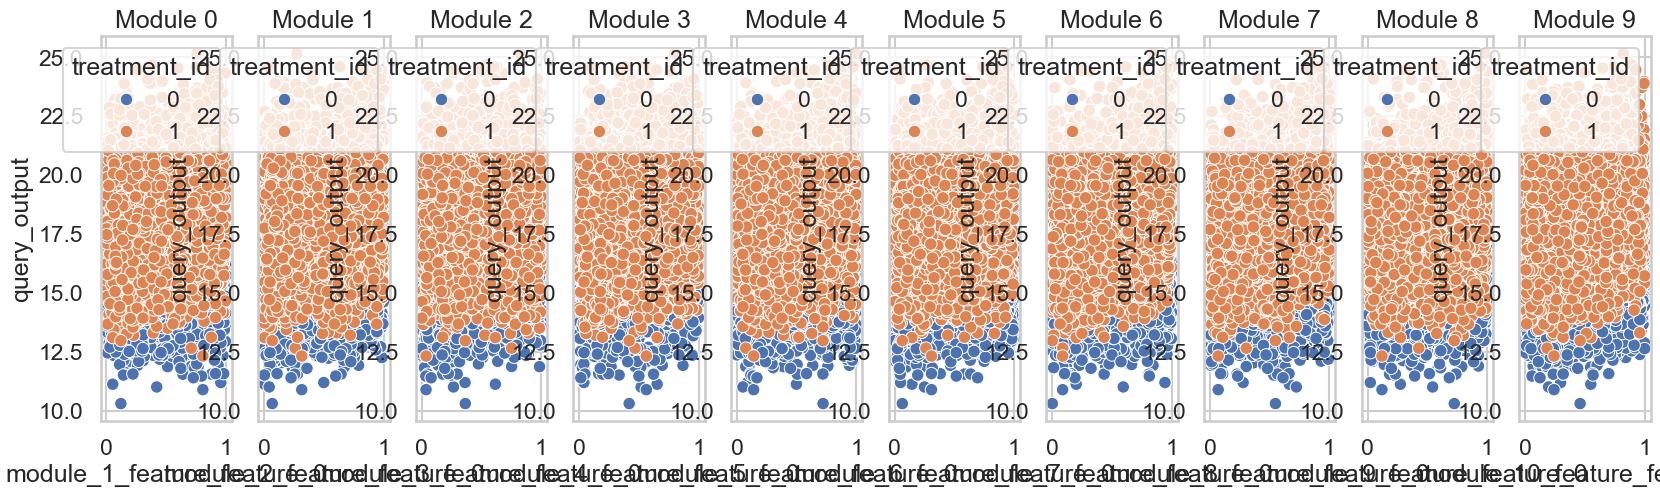

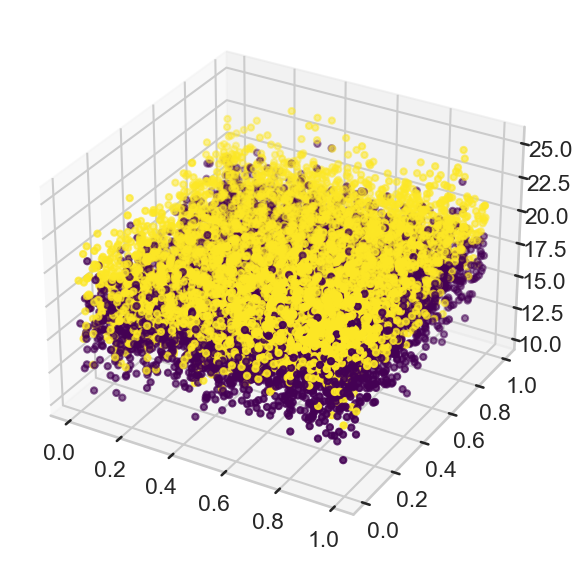

In [4]:
# Hypotheses to test
# 1. Each component output is a quadratic function of the input features.
# 2. Plot final output vs input features.

# Hypothesis 1
# plot 1
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("talk")
fig, ax = plt.subplots(1, num_modules, figsize=(20, 5))
for i in range(num_modules):
    sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"module_{i+1}_output", data=data, ax=ax[i],hue="treatment_id")
    ax[i].set_title(f"Module {i}")

fig, ax = plt.subplots(1, num_modules, figsize=(20, 5))
for i in range(num_modules):
    sns.scatterplot(x=f"module_{i+1}_feature_feature_0", y=f"query_output", data=data, ax=ax[i],hue="treatment_id")
    ax[i].set_title(f"Module {i}")

# Have a 3D plot for two features and one output
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["module_1_feature_feature_0"], data["module_2_feature_feature_0"], data["query_output"], c=data["treatment_id"], cmap='viridis')



# Observational sampling

,query_id,tree_depth,num_module_1,num_module_2,num_module_3,num_module_4,num_module_5,num_module_6,num_module_7,num_module_8,...,module_3_output,module_4_output,module_5_output,module_6_output,module_7_output,module_8_output,module_9_output,module_10_output,query_output,treatment_id
0,0,10,1,1,1,1,1,1,1,1,...,1.210324,1.501760,1.720521,0.711715,2.602749,2.506780,2.288691,0.993135,16.953947,1
1,1,10,1,1,1,1,1,1,1,1,...,0.241700,0.454488,1.589451,2.167071,3.239255,1.590278,1.498974,0.761172,15.635186,0
2,2,10,1,1,1,1,1,1,1,1,...,1.866917,1.364879,1.384356,0.913819,2.073418,3.073736,2.091439,2.085855,17.328026,1
3,3,10,1,1,1,1,1,1,1,1,...,0.704699,1.259706,1.128964,3.212200,2.105149,1.722400,1.302079,0.871435,14.614737,0
4,4,10,1,1,1,1,1,1,1,1,...,1.245084,0.865042,1.551241,1.598784,1.645959,3.170265,2.485864,0.288391,15.949904,1


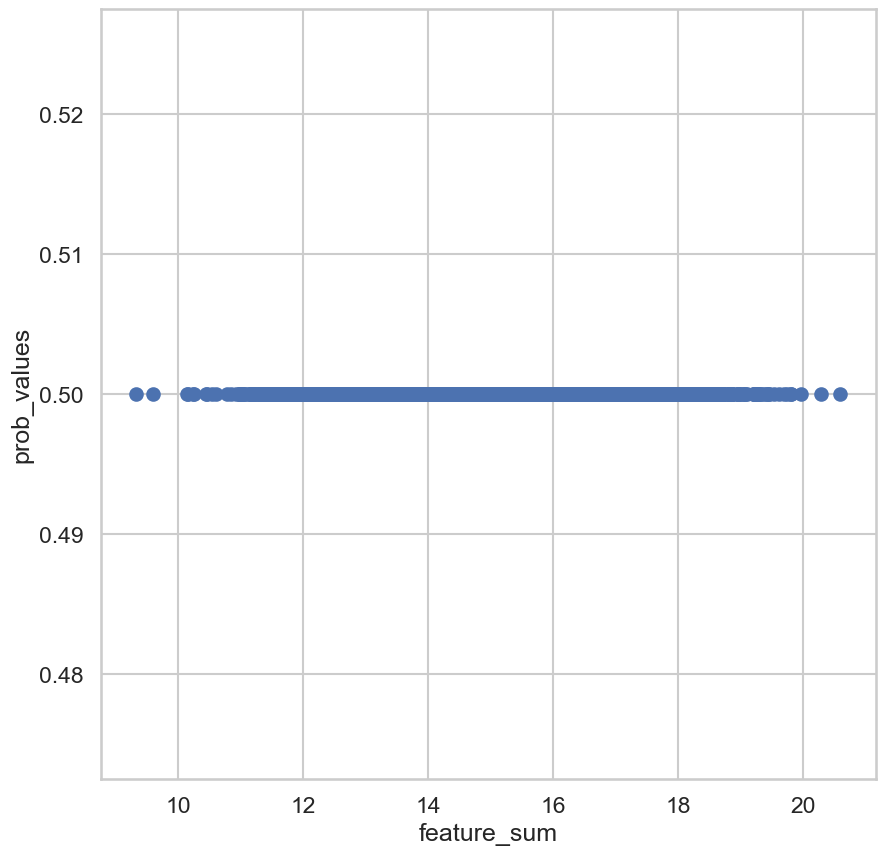

In [5]:
# Create observational data
results = sampler.create_observational_data(biasing_covariate="feature_sum", bias_strength=0)
df_sampled = pd.read_csv("/Users/ppruthi/research/novelty_accommodation/compositional_models_cate/domains/synthetic_data/observational_data/fixed_structure_True_outcomes_parallel/feature_sum_0/df_sampled.csv")
df_sampled.head()

# Train/test split

In [6]:
sampler.create_iid_ood_split(split_type = "iid", test_size = 0.2)
train_test_qids_path = "/Users/ppruthi/research/novelty_accommodation/compositional_models_cate/domains/synthetic_data/csvs/fixed_structure_True_outcomes_parallel/iid/train_test_split_qids.json"
with open(train_test_qids_path, "r") as f:
    train_test_qids = json.load(f)
train_qids = train_test_qids["train"]
test_qids = train_test_qids["test"]

# Data baseline model 

In [7]:
train_df = df_sampled[df_sampled["query_id"].isin(train_qids)]
test_df = df_sampled[df_sampled["query_id"].isin(test_qids)]

In [8]:
# test one of the baselines 
from models.baselines import *
from models.MoE import *
covariates = [x for x in train_df.columns if "feature" in x]
print(covariates)
treatment = "treatment_id"
outcome = "query_output"
# X_test = test_df[covariates].values
test_df = train_df
input_dim = len(covariates)
output_dim = 1
hidden_dim = 128
epochs = 100
batch_size = 64
baseline_model = BaselineModel(input_dim + 1, hidden_dim, output_dim)
train_model(baseline_model, train_df, covariates, treatment, outcome, epochs, batch_size)
causal_effect_estimates = predict_model(baseline_model, test_df, covariates)
# causal_effect_estimates = x_learner(train_df, covariates, treatment, outcome, X_test=None)
test_df.loc[:, "estimated_effect"] = causal_effect_estimates

['module_1_feature_feature_0', 'module_1_feature_feature_1', 'module_1_feature_feature_2', 'module_2_feature_feature_0', 'module_2_feature_feature_1', 'module_2_feature_feature_2', 'module_3_feature_feature_0', 'module_3_feature_feature_1', 'module_3_feature_feature_2', 'module_4_feature_feature_0', 'module_4_feature_feature_1', 'module_4_feature_feature_2', 'module_5_feature_feature_0', 'module_5_feature_feature_1', 'module_5_feature_feature_2', 'module_6_feature_feature_0', 'module_6_feature_feature_1', 'module_6_feature_feature_2', 'module_7_feature_feature_0', 'module_7_feature_feature_1', 'module_7_feature_feature_2', 'module_8_feature_feature_0', 'module_8_feature_feature_1', 'module_8_feature_feature_2', 'module_9_feature_feature_0', 'module_9_feature_feature_1', 'module_9_feature_feature_2', 'module_10_feature_feature_0', 'module_10_feature_feature_1', 'module_10_feature_feature_2']


In [9]:
input_dim

30

# Model Evaluation

In [10]:

def get_ground_truth_effects(data, qids, treatment_col='treatment_id', outcome_col='query_output'):
    

    # get ground truth effects from data 
    # Group by query_id and treatment_id, then unstack to have treatments as columns
    grouped = data.groupby(['query_id', treatment_col])[outcome_col].first().unstack()

    # Calculate the causal effect (treatment 1 - treatment 0)
    causal_effect = grouped[1] - grouped[0]

    # Convert to dictionary
    causal_effect_dict = causal_effect.to_dict()

    causal_effect_dict_test = {k: v for k, v in causal_effect_dict.items() if k in qids}
    return causal_effect_dict_test



In [11]:
test_df

,query_id,tree_depth,num_module_1,num_module_2,num_module_3,num_module_4,num_module_5,num_module_6,num_module_7,num_module_8,...,module_4_output,module_5_output,module_6_output,module_7_output,module_8_output,module_9_output,module_10_output,query_output,treatment_id,estimated_effect
0,0,10,1,1,1,1,1,1,1,1,...,1.501760,1.720521,0.711715,2.602749,2.506780,2.288691,0.993135,16.953947,1,4.021716
1,1,10,1,1,1,1,1,1,1,1,...,0.454488,1.589451,2.167071,3.239255,1.590278,1.498974,0.761172,15.635186,0,4.015666
2,2,10,1,1,1,1,1,1,1,1,...,1.364879,1.384356,0.913819,2.073418,3.073736,2.091439,2.085855,17.328026,1,1.087862
3,3,10,1,1,1,1,1,1,1,1,...,1.259706,1.128964,3.212200,2.105149,1.722400,1.302079,0.871435,14.614737,0,3.221128
4,4,10,1,1,1,1,1,1,1,1,...,0.865042,1.551241,1.598784,1.645959,3.170265,2.485864,0.288391,15.949904,1,1.425665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,10,1,1,1,1,1,1,1,1,...,0.408324,1.433180,2.695050,1.681287,1.253849,1.162132,0.637141,14.198333,0,2.409688
4996,4996,10,1,1,1,1,1,1,1,1,...,2.056634,2.260640,3.095638,1.854240,1.191035,0.994412,0.675152,17.708635,0,1.521133
4997,4997,10,1,1,1,1,1,1,1,1,...,1.428579,1.540981,0.705784,1.018288,3.207637,2.776396,1.678092,16.146564,1,1.945521
4998,4998,10,1,1,1,1,1,1,1,1,...,1.081328,1.878471,2.440095,1.457185,1.512987,1.043620,1.028489,14.779590,0,1.047095


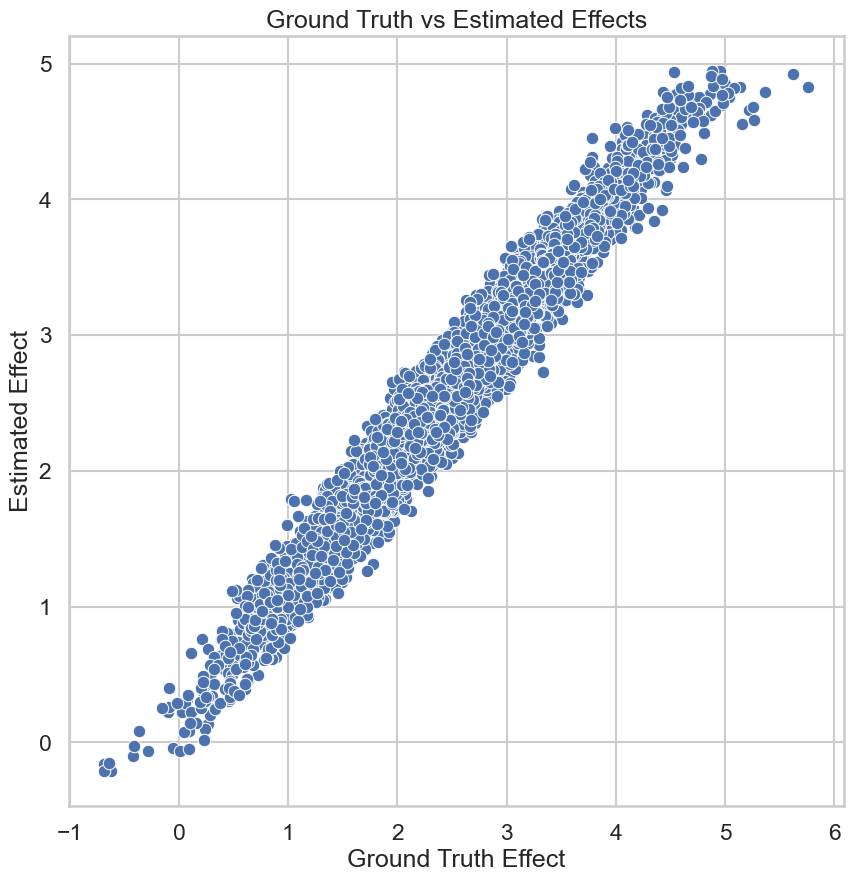

In [12]:
# create a dictionary of estimated effects from test_df 


def get_estimated_effects(data, qids):
    estimated_effects = data.groupby("query_id")["estimated_effect"].first().to_dict()
    estimated_effects_test = {k: v for k, v in estimated_effects.items() if k in qids}
    return estimated_effects_test

baseline_estimated_effects = get_estimated_effects(test_df, train_qids)
baseline_causal_effect_dict_test = get_ground_truth_effects(data, train_qids)


# have combined df with ground truth and estimated effects
baseline_combined_df = pd.DataFrame({"ground_truth_effect": list(baseline_causal_effect_dict_test.values()), "estimated_effect": list(baseline_estimated_effects.values())})


# scatter plot of ground truth vs estimated effects
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(x="ground_truth_effect", y="estimated_effect", data=baseline_combined_df, ax=ax)
ax.set_xlabel("Ground Truth Effect")
ax.set_ylabel("Estimated Effect")
ax.set_title("Ground Truth vs Estimated Effects")

plt.show()



In [13]:
baseline_combined_df

,ground_truth_effect,estimated_effect
0,3.878808,4.021716
1,4.009414,4.015666
2,0.980077,1.087862
3,3.090162,3.221128
4,1.244398,1.425665
...,...,...
4794,2.385999,2.409688
4795,1.207494,1.521133
4796,2.277826,1.945521
4797,0.897457,1.047095


In [14]:
# Moe models
# have a MoE model with the same data
moe_model = MoE(input_dim+1, hidden_dim, output_dim, num_modules)
train_model(moe_model, train_df, covariates, treatment, outcome, epochs, batch_size)
moe_causal_effect_estimates = predict_model(moe_model, test_df, covariates)
test_df.loc[:, "estimated_effect"] = moe_causal_effect_estimates
moe_estimated_effects = get_estimated_effects(test_df, train_qids)
baseline_combined_df["estimated_effect_moe"] = list(moe_estimated_effects.values())

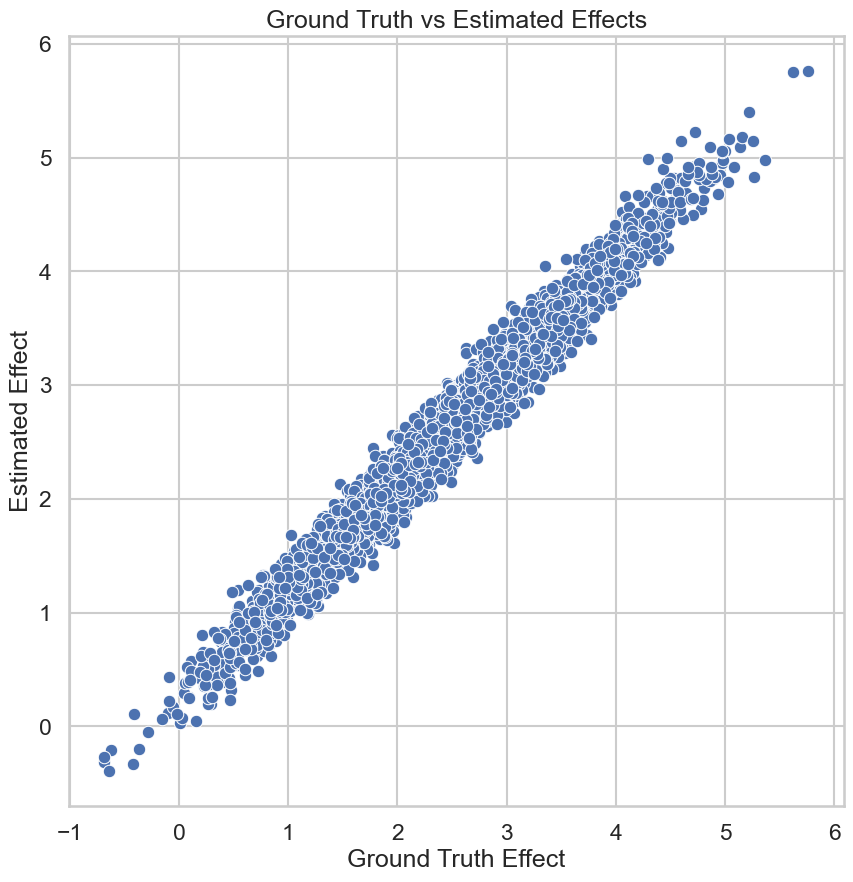

In [15]:
# scatter plot of ground truth vs estimated effects
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.scatterplot(x="ground_truth_effect", y="estimated_effect_moe", data=baseline_combined_df, ax=ax)
ax.set_xlabel("Ground Truth Effect")
ax.set_ylabel("Estimated Effect")
ax.set_title("Ground Truth vs Estimated Effects")

plt.show()

In [16]:
X = test_df[covariates].values
X_1 = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
X_1 = torch.tensor(X_1, dtype=torch.float32)
print(X_1.shape)
# get the gate values
gate_values = moe_model.gate(X_1).detach().numpy()
# gate_values = np.argmax(gate_values, axis=1)

# # count the number of times each gate is selected
gate_values
# np.unique(gate_values, return_counts=True)


torch.Size([4799, 31])


array([[0.07535125, 0.15601978, 0.23312423, ..., 0.08675661, 0.03140919,
        0.0497362 ],
       [0.05394807, 0.15928409, 0.2846123 , ..., 0.07353317, 0.02521383,
        0.03801976],
       [0.09068818, 0.10151714, 0.1789223 , ..., 0.09869155, 0.02887763,
        0.04962964],
       ...,
       [0.06860119, 0.09931679, 0.16523483, ..., 0.10244614, 0.03487527,
        0.05560049],
       [0.06169161, 0.11362462, 0.16334529, ..., 0.09456026, 0.02825442,
        0.06524859],
       [0.06475417, 0.10712049, 0.2874825 , ..., 0.08547231, 0.02404585,
        0.04808184]], dtype=float32)

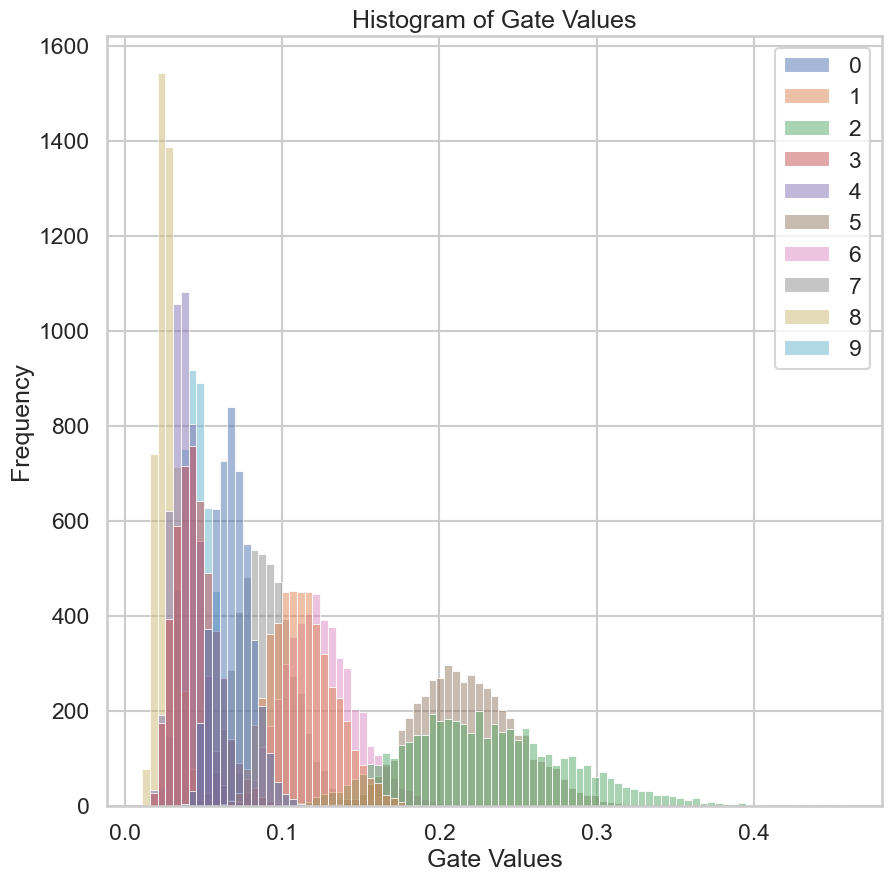

In [17]:
# draw histogram of gate values
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.histplot(gate_values, ax=ax)
ax.set_xlabel("Gate Values")
ax.set_ylabel("Frequency")
ax.set_title("Histogram of Gate Values")

plt.show()

## Additive Parallel Model Implementation

## Read module data


In [18]:
# read all the module files 
module_files = os.listdir("/Users/ppruthi/research/novelty_accommodation/compositional_models_cate/domains/synthetic_data/csvs/fixed_structure_True_outcomes_parallel/")
module_files = [x for x in module_files if "module" in x]

# read all the module files
module_data = {}
for module_file in module_files:
    module_data[module_file] = pd.read_csv(f"/Users/ppruthi/research/novelty_accommodation/compositional_models_cate/domains/synthetic_data/csvs/fixed_structure_True_outcomes_parallel/{module_file}")
    print(module_data[module_file].head())

   query_id  treatment_id  feature_0  feature_1  feature_2    output
0      2017             0   0.139736   0.386936   0.875397  0.985712
1      2447             0   0.506135   0.352305   0.459823  0.959718
2       812             0   0.044840   0.713847   0.929686  1.315547
3      3606             0   0.974013   0.074577   0.134719  1.174084
4      2914             0   0.486185   0.904812   0.257408  1.414486
   query_id  treatment_id  feature_0  feature_1  feature_2    output
0      2017             0   0.989274   0.768370   0.614369  2.513122
1      2447             0   0.017268   0.628599   0.453642  1.369179
2       812             0   0.211507   0.640219   0.040241  1.258481
3      3606             0   0.814193   0.727745   0.317371  2.044611
4      2914             0   0.165663   0.141491   0.154880  0.699200
   query_id  treatment_id  feature_0  feature_1  feature_2    output
0      2017             0   0.811111   0.902017   0.749583  1.414577
1      2447             0   0.4627

# observational_biasing

In [19]:
# filter the rows where treatment_id is equal to the treatment_id in the json file
# first select the treatment_id based on the query_id
query_id_treatment_id_json_path = "/Users/ppruthi/research/novelty_accommodation/compositional_models_cate/domains/synthetic_data/observational_data/fixed_structure_True_outcomes_parallel/feature_sum_0/treatment_assignments.json"
with open(query_id_treatment_id_json_path, "r") as f:
    query_id_treatment_id = json.load(f)
train_data = {}
test_data = {}
for module_file in module_files:
    module_df = module_data[module_file]
    print(module_df.shape)
    module_df["assigned_treatment_id"] = module_df["query_id"].apply(lambda x: query_id_treatment_id[str(x)])
    module_df = module_df[module_df["treatment_id"] == module_df["assigned_treatment_id"]]
    print(module_df.shape)
    # drop the assigned treatment id
    module_df.drop("assigned_treatment_id", axis=1, inplace=True)
    # split the data into train and test
    train_data[module_file] = module_df[module_df["query_id"].isin(train_qids)]
    test_data[module_file] = module_df[module_df["query_id"].isin(test_qids)]
    print(train_data[module_file].shape, test_data[module_file].shape)
    

(10000, 6)
(5000, 7)
(4799, 6) (201, 6)
(10000, 6)
(5000, 7)
(4799, 6) (201, 6)
(10000, 6)
(5000, 7)
(4799, 6) (201, 6)
(10000, 6)
(5000, 7)
(4799, 6) (201, 6)
(10000, 6)
(5000, 7)
(4799, 6) (201, 6)
(10000, 6)
(5000, 7)
(4799, 6) (201, 6)
(10000, 6)
(5000, 7)
(4799, 6) (201, 6)
(10000, 6)
(5000, 7)
(4799, 6) (201, 6)
(10000, 6)
(5000, 7)
(4799, 6) (201, 6)
(10000, 6)
(5000, 7)
(4799, 6) (201, 6)


In [20]:
# test one of the baselines 
from models.baselines import *
for module_file in module_files:
    train_df = train_data[module_file]
    covariates = [x for x in train_df.columns if "feature" in x]
    treatment = "treatment_id"
    outcome = "output"
    input_dim = len(covariates)
    output_dim = 1
    hidden_dim = 64
    epochs = 100
    expert_model = BaselineModel(input_dim + 1, hidden_dim, output_dim)
    train_model(expert_model, train_df, covariates, treatment, outcome, epochs, batch_size)
    causal_effect_estimates = predict_model(expert_model, train_df, covariates)
    train_df["estimated_effect"] = causal_effect_estimates
    train_data[module_file] = train_df
    
    

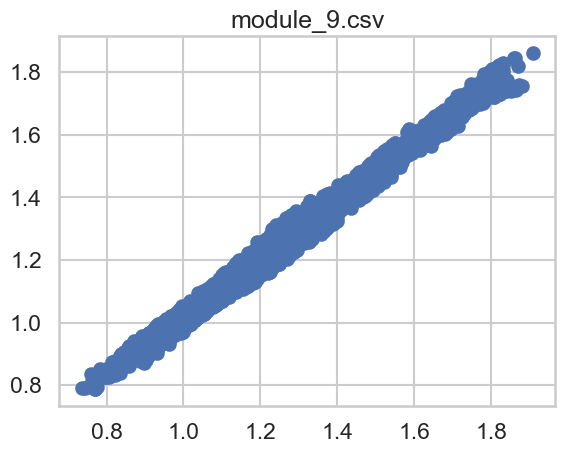

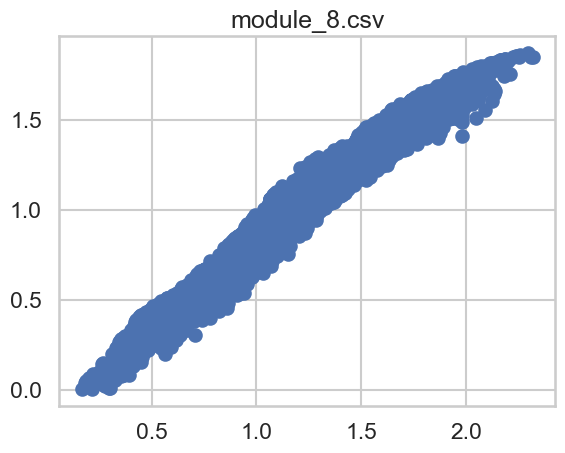

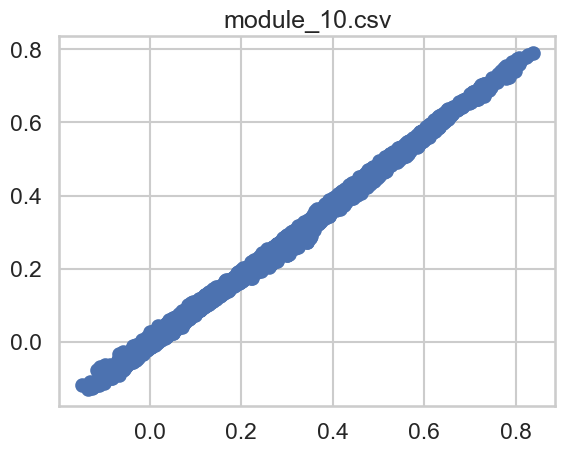

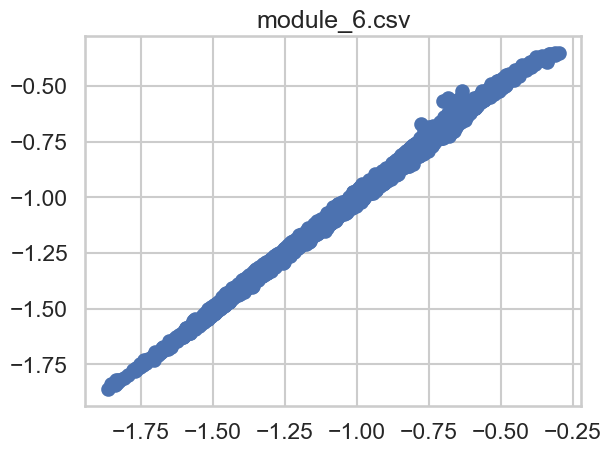

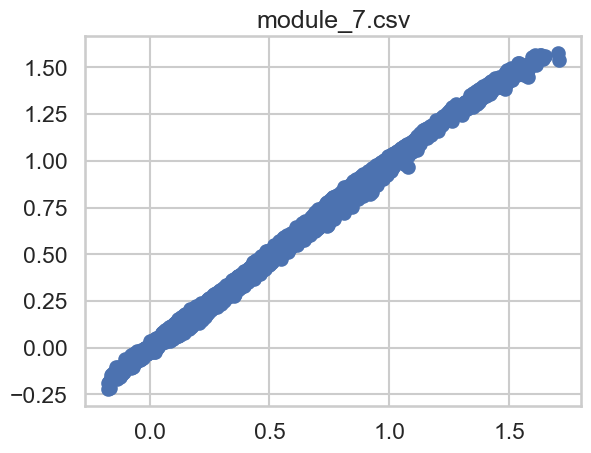

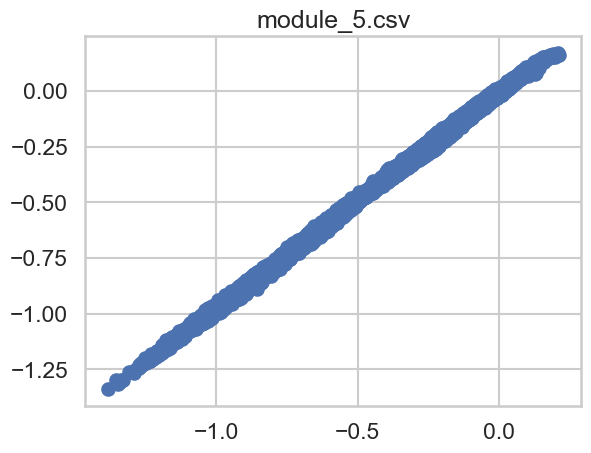

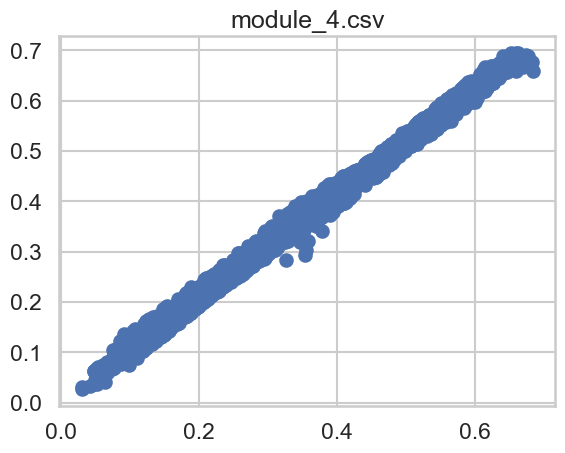

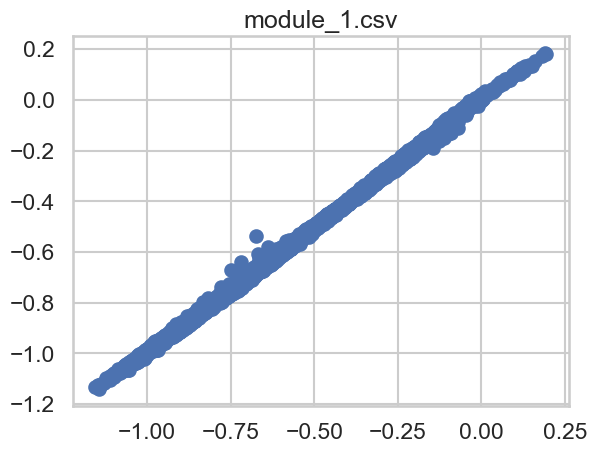

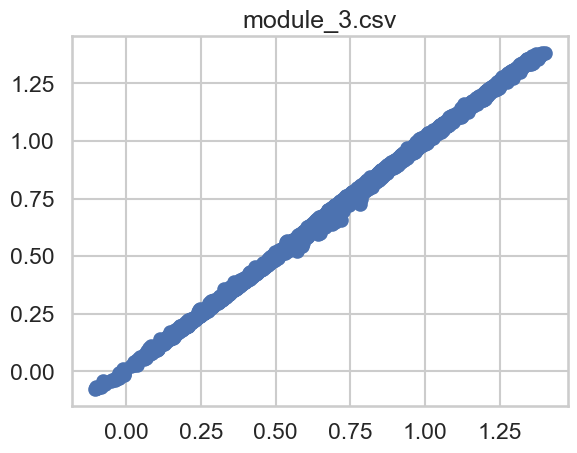

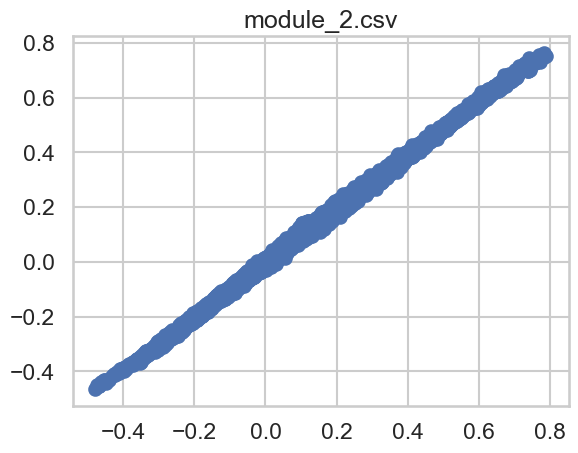

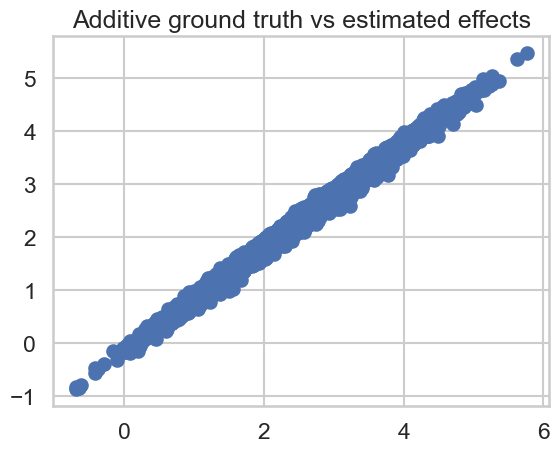

In [21]:
# now for each module, get the ground truth and estimated effects
additive_ground_truth_effects = {}
additive_estimated_effects = {}
for module_file in module_files:
    train_df = train_data[module_file]
    test_df = test_data[module_file]
    module_causal_effect_dict_test = get_ground_truth_effects(module_data[module_file], train_qids, treatment_col="treatment_id", outcome_col="output")
    module_estimated_effects = get_estimated_effects(train_df, train_qids)
    module_combined_df = pd.DataFrame({"ground_truth_effect": list(module_causal_effect_dict_test.values()), "estimated_effect": list(module_estimated_effects.values())})
    if len(additive_estimated_effects) == 0:
        additive_ground_truth_effects = module_causal_effect_dict_test
        additive_estimated_effects = module_estimated_effects
    else:
        # add the effects
        additive_ground_truth_effects = {k: v + module_causal_effect_dict_test[k] for k, v in additive_ground_truth_effects.items()}
        additive_estimated_effects = {k: v + module_estimated_effects[k] for k, v in additive_estimated_effects.items()}
    plt.scatter(module_combined_df["ground_truth_effect"], module_combined_df["estimated_effect"])
    plt.title(module_file)
    plt.show()

# scatter plot of ground truth vs estimated effects
additive_combined_df = pd.DataFrame({"ground_truth_effect": additive_ground_truth_effects, "estimated_effect": additive_estimated_effects})
plt.scatter(additive_combined_df["ground_truth_effect"], additive_combined_df["estimated_effect"])
plt.title("Additive ground truth vs estimated effects")
plt.show()

In [22]:
# combine the two dataframes: baseline_combined_df and additive_combined_df on query_id
baseline_combined_df["query_id"] = list(baseline_combined_df.index)
additive_combined_df["query_id"] = list(additive_combined_df.index)
combined_df = pd.merge(baseline_combined_df, additive_combined_df, on="query_id", suffixes=("_baseline", "_additive"))
combined_df.head()



,ground_truth_effect_baseline,estimated_effect_baseline,estimated_effect_moe,query_id,ground_truth_effect_additive,estimated_effect_additive
0,3.878808,4.021716,3.929964,0,3.878808,3.730498
1,4.009414,4.015666,4.184389,1,4.009414,3.746127
2,0.980077,1.087862,1.104591,2,0.980077,0.755663
3,3.090162,3.221128,3.166786,3,3.090162,2.885960
4,1.244398,1.425665,1.453590,4,1.244398,0.938377


In [23]:
# calculate pehe for the two models
def pehe(ground_truth, estimated):
    return np.sqrt(np.mean((ground_truth - estimated)**2))

pehe_baseline = pehe(combined_df["ground_truth_effect_baseline"], combined_df["estimated_effect_baseline"])
pehe_additive = pehe(combined_df["ground_truth_effect_additive"], combined_df["estimated_effect_additive"])
pehe_moe = pehe(combined_df["ground_truth_effect_baseline"], combined_df["estimated_effect_moe"])
print(f"PEHE for baseline model: {pehe_baseline}")
print(f"PEHE for additive model: {pehe_additive}")
print(f"PEHE for MoE model: {pehe_moe}")

PEHE for baseline model: 0.2153618304216902
PEHE for additive model: 0.20854606989945523
PEHE for MoE model: 0.21987928195181775
